In [1]:
import argparse
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

parser = argparse.ArgumentParser()
parser.add_argument("--data", default="data_ford.csv", type=str, help="Path to data.")
args = parser.parse_args([] if "__file__" not in globals() else None)

In [2]:
df = pd.read_csv(args.data)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1972-06-01,0.000000,2.173495,2.149165,2.153220,0.248348,1091238
1,1972-06-02,2.153220,2.173495,2.141055,2.149165,0.247881,1174468
2,1972-06-05,2.149165,2.169440,2.141055,2.149165,0.247881,5209582
3,1972-06-06,2.149165,2.157275,2.116725,2.124835,0.245075,1424158
4,1972-06-07,2.124835,2.137000,2.112670,2.112670,0.243672,675088


In [3]:
def plot_df(df):
    plt.plot(df.index, df["Close"], label="Close price of stocks per day")
    plt.legend()
    plt.show()

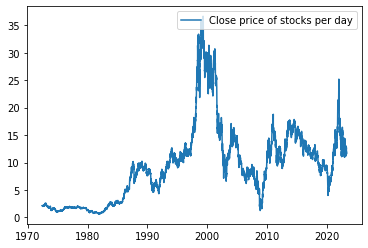

In [4]:
df = df[["Date", "Close"]]
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

plot_df(df)

In [5]:
train, test = df.loc[df.index < "2015-01-01"], df.loc[df.index >= "2015-01-01"]
print(f"number of test examples: {len(test)}")
print(f"number of train examples: {len(train)}")

number of test examples: 2095
number of train examples: 10743


C:\Users\samue\AppData\Local\Temp\ipykernel_24780\3078533429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Close"] = scaler.transform(train[["Close"]])
C:\Users\samue\AppData\Local\Temp\ipykernel_24780\3078533429.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Close"] = scaler.transform(test[["Close"]])


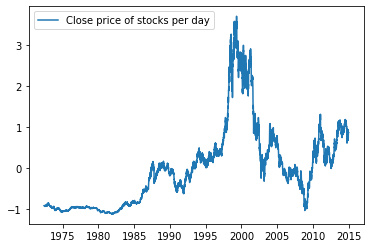

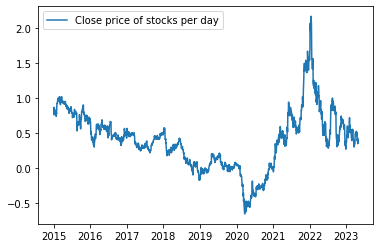

In [6]:
scaler = StandardScaler()
scaler = scaler.fit(train[["Close"]])

train["Close"] = scaler.transform(train[["Close"]])
test["Close"] = scaler.transform(test[["Close"]])

plot_df(train)
plot_df(test)

In [7]:
SEQUENCE_LENGTH = 30

def create_time_seqs(x: pd.DataFrame, seq_len: int=SEQUENCE_LENGTH):

    res = []
    for i in range(len(x) - seq_len):
        res.append(x.iloc[i: i+seq_len].to_numpy())

    return np.array(res)

In [8]:
train_inputs, train_labels = create_time_seqs(train), create_time_seqs(train)
test_inputs, test_labels = create_time_seqs(test), create_time_seqs(test)

In [9]:
def get_autoencoder_model(input_shape: tuple) -> tf.keras.Model:
    inputs = tf.keras.layers.Input(shape=input_shape)

    encoder_part = tf.keras.layers.LSTM(128, return_sequences=True)(inputs)
    encoder_part = tf.keras.layers.Dropout(0.2)(encoder_part)
    encoder_part = tf.keras.layers.LSTM(64)(encoder_part)

    encoder_decoder_bridge = tf.keras.layers.RepeatVector(input_shape[0])(encoder_part)

    decoder_part = tf.keras.layers.LSTM(64, return_sequences=True)(encoder_decoder_bridge)
    decoder_part = tf.keras.layers.Dropout(0.2)(decoder_part)
    decoder_part = tf.keras.layers.LSTM(128, return_sequences=True)(decoder_part)
    outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(input_shape[1], activation=None))(decoder_part)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.mean_absolute_error,
    )

    return model


In [10]:
NUM_FEATURES = 1
EPOCHS = 500

model = get_autoencoder_model((SEQUENCE_LENGTH, NUM_FEATURES))
fit_history = model.fit(
    train_inputs,
    train_labels,
    32,
    epochs=EPOCHS,
    validation_split=0.1
)

Epoch 1/500
302/302 [==============================] - 13s 24ms/step - loss: 0.1063 - val_loss: 0.0743
Epoch 2/500
302/302 [==============================] - 7s 22ms/step - loss: 0.0594 - val_loss: 0.0653
Epoch 3/500
302/302 [==============================] - 6s 20ms/step - loss: 0.0513 - val_loss: 0.0461
Epoch 4/500
302/302 [==============================] - 6s 20ms/step - loss: 0.0425 - val_loss: 0.0485
Epoch 5/500
302/302 [==============================] - 5s 17ms/step - loss: 0.0412 - val_loss: 0.0536
Epoch 6/500
302/302 [==============================] - 4s 14ms/step - loss: 0.0385 - val_loss: 0.0475
Epoch 7/500
302/302 [==============================] - 5s 17ms/step - loss: 0.0361 - val_loss: 0.0431
Epoch 8/500
302/302 [==============================] - 6s 19ms/step - loss: 0.0331 - val_loss: 0.0569
Epoch 9/500
302/302 [==============================] - 6s 19ms/step - loss: 0.0353 - val_loss: 0.0363
Epoch 10/500
302/302 [==============================] - 6s 19ms/step - loss: 0.03

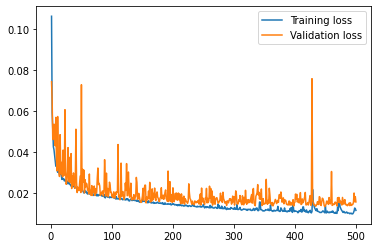

In [21]:
x_axes = np.arange(1, EPOCHS+1)
plt.plot(x_axes, fit_history.history["loss"], label="Training loss")
plt.plot(x_axes, fit_history.history["val_loss"], label="Validation loss")
plt.legend()
plt.show()

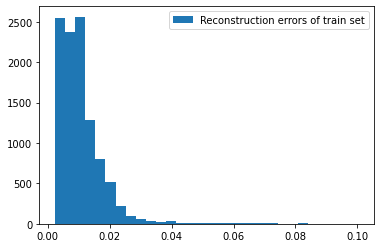

In [22]:
predicted = model(train_inputs)
train_predicted_MAE = np.mean(np.abs(predicted - train_labels), 1).reshape(-1)
plt.hist(train_predicted_MAE, bins=30, label="Reconstruction errors of train set")
plt.legend()
plt.show()

In [23]:
train_predicted_MAE.sort()
anomalies_percent = 0.05
reconstruction_MAE_treshold = train_predicted_MAE[int(len(train_predicted_MAE) * (1 - anomalies_percent))]
print(reconstruction_MAE_treshold)

0.023087287


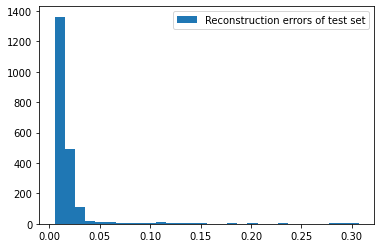

In [24]:
predicted = model(test_inputs)
test_predicted_MAE = np.mean(np.abs(predicted - test_labels), 1).reshape(-1)
plt.hist(test_predicted_MAE, bins=30, label="Reconstruction errors of test set")
plt.legend()
plt.show()

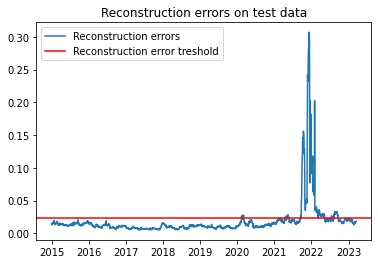

In [34]:
plt.plot(test.index[:-SEQUENCE_LENGTH], test_predicted_MAE, label="Reconstruction errors")
plt.axhline(y=reconstruction_MAE_treshold, color='r', label="Reconstruction error treshold")
plt.title("Reconstruction errors on test data")
plt.legend()
plt.show()